In [40]:
import requests
from PIL import Image, ImageDraw
import torch

from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import skimage.transform

import sys
import numpy as np

sys.path.append("..")

In [44]:
processor = AutoProcessor.from_pretrained("google/owlvit-base-patch32")
model = AutoModelForZeroShotObjectDetection.from_pretrained(
    "google/owlvit-base-patch32"
)

device = "cuda"

image = Image.open("/home/dbogdoll/mcity_data_engine/scripts/fisheye_test.png").convert(
    "RGB"
)
image_np = np.array(image).astype(np.float32) / 255.0

# Calculate padding to make the image square
h, w, _ = image_np.shape
size = max(h, w)
padding = ((0, size - h), (0, size - w), (0, 0))

# Pad the image with gray pixels (value 0.5)
image_padded = np.pad(image_np, padding, constant_values=0.5)

# Resize the padded image to 768x768
input_image = skimage.transform.resize(image_padded, (768, 768), anti_aliasing=True)

# Convert back to PIL Image if needed
image = Image.fromarray((input_image * 255).astype(np.uint8))

# Print the resolution and padding information
print(f"Original resolution: {h}x{w}")
print(f"Padded resolution: {image_padded.shape[0]}x{image_padded.shape[1]}")
print(f"Final resolution: {input_image.shape[0]}x{input_image.shape[1]}")
print(f"Padding added: height={size - h}, width={size - w}")

# image = Image.open("/home/dbogdoll/mcity_data_engine/scripts/fisheye_small.png").convert(
#    "RGB"
# )

texts = [
    "car",
    "truck",
    "bus",
]
tokenized_texts = processor.tokenizer(texts, padding="max_length", return_tensors="pt")

# Preprocess image
inputs = processor.image_processor(text=None, images=image, return_tensors="pt")

# Update inputs with tokenized text fields
inputs.update(tokenized_texts)

# Forward pass
outputs = model(**inputs)

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([image.size[::-1]])
print(target_sizes)
# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process_object_detection(
    outputs=outputs, threshold=0.1, target_sizes=target_sizes
)

i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Print detected objects and rescaled box coordinates
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}"
    )

Original resolution: 1852x3287
Padded resolution: 3287x3287


AttributeError: 'Image' object has no attribute 'shape'

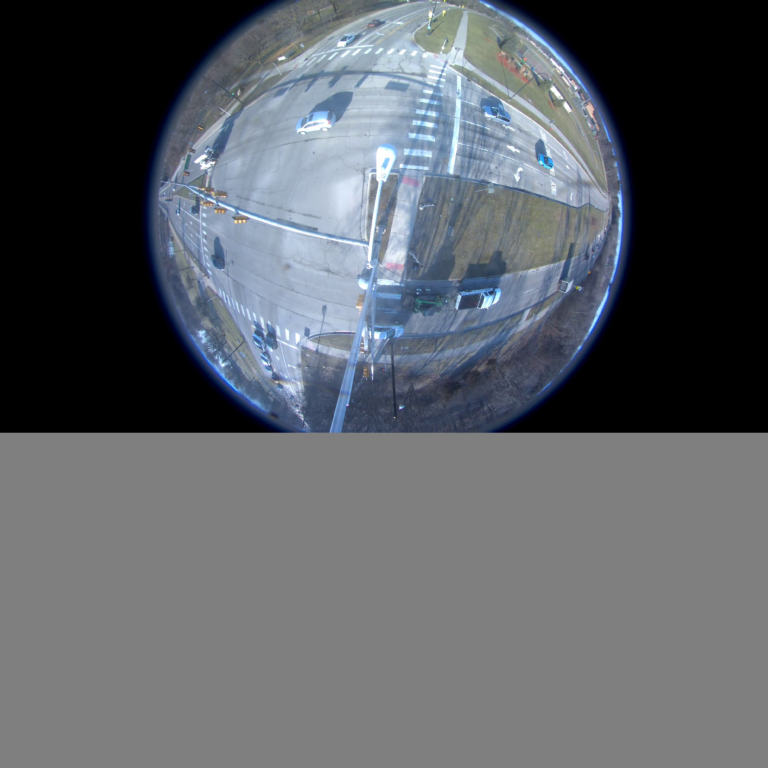

In [42]:
# Draw bounding boxes on the image
draw = ImageDraw.Draw(image)
for box, label in zip(boxes, labels):
    draw.rectangle(box.tolist(), outline="red", width=2)
    draw.text((box[0], box[1]), text[label], fill="red")

# Display the image
display(image)

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x728A4BD04470>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=639x428 at 0x728A9183D9A0>, <PIL.Image.Image image mode=RGB size=480x270 at 0x728A9CDA8E90>, <PIL.Image.Image image mode=RGB size=480x270 at 0x728A9A029D90>]
['cat', 'remote control', 'birdcar', 'truck', 'bus', 'crosswalk', 'sky', 'cat', 'remote control', 'birdcar', 'truck', 'bus', 'crosswalk', 'sky', 'cat', 'remote control', 'birdcar', 'truck', 'bus', 'crosswalk', 'sky', 'cat', 'remote control', 'birdcar', 'truck', 'bus', 'crosswalk', 'sky']
{'input_ids': tensor([[49406,  2368, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [49406,  9687,  3366, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [49406,  6908,  1615, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
       

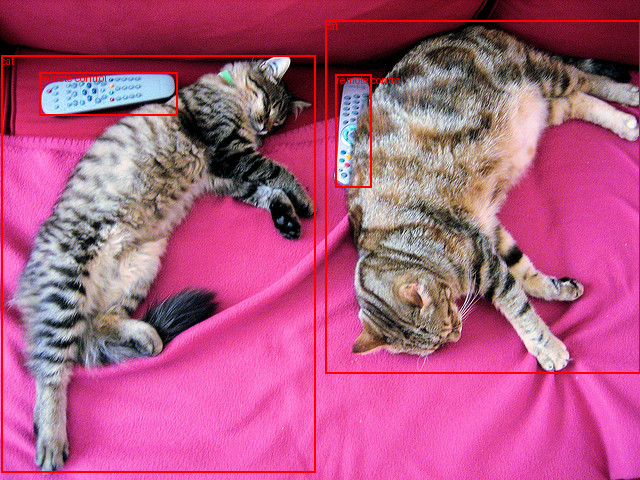

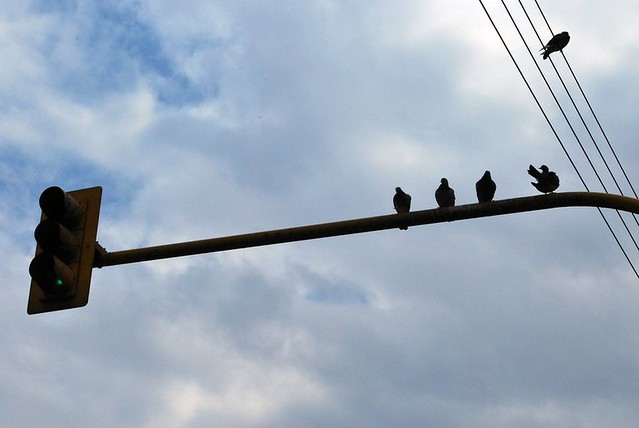

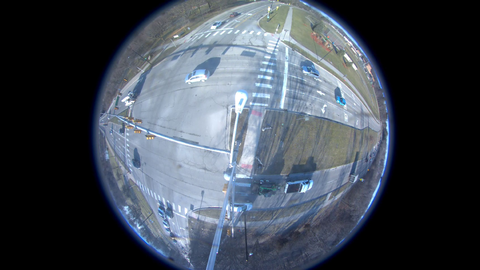

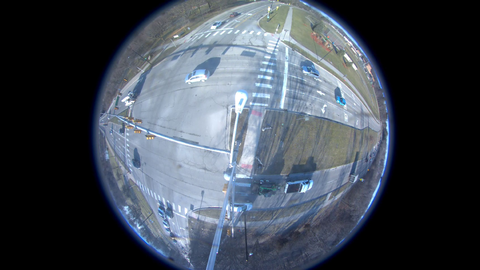

In [27]:
import requests
from PIL import Image
import torch
from transformers import (
    AutoProcessor,
    AutoModelForZeroShotObjectDetection,
)

import numpy as np

# Load the processor and model
processor = AutoProcessor.from_pretrained("google/owlvit-base-patch32")
model = AutoModelForZeroShotObjectDetection.from_pretrained(
    "google/owlvit-base-patch32"
).to(device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load images
urls = [
    "http://images.cocodataset.org/val2017/000000039769.jpg",
    "https://farm4.staticflickr.com/3154/2913892833_c740d2ca64_z.jpg",
]
images_web = [Image.open(requests.get(url, stream=True).raw) for url in urls]

images = [
    Image.open("/home/dbogdoll/mcity_data_engine/scripts/fisheye_test.png").convert(
        "RGB"
    ),
    Image.open("/home/dbogdoll/mcity_data_engine/scripts/fisheye_test.png").convert(
        "RGB"
    ),
]

images_new = []
for img in images:
    base_width = 480
    wpercent = base_width / float(img.size[0])
    hsize = int((float(img.size[1]) * float(wpercent)))
    img = img.resize((base_width, hsize), Image.Resampling.LANCZOS)
    images_new.append(img)

images = images_web + images_new
print(images)

# texts = ["cat", "remote control", "dog", "traffic light"]
texts = ["cat", "remote control", "bird" "car", "truck", "bus", "crosswalk", "sky"]

texts = texts * 4
print(texts)

# Process images with the processor
inputs = processor(text=texts, images=images, return_tensors="pt").to(device)
print(inputs)
# Forward pass
with torch.amp.autocast("cuda"):
    with torch.no_grad():
        outputs = model(**inputs)

target_sizes = [x.size[::-1] for x in images]
print(target_sizes)
print(outputs)
results = processor.post_process_object_detection(
    outputs=outputs, threshold=0.1, target_sizes=target_sizes
)


print(results)
for image, result in zip(images, results):
    boxes, scores, labels = result["boxes"], result["scores"], result["labels"]

    # Draw bounding boxes on the image
    draw = ImageDraw.Draw(image)
    for box, label in zip(boxes, labels):
        draw.rectangle(box.tolist(), outline="red", width=2)
        draw.text((box[0], box[1]), texts[label], fill="red")

    # Display the image
    display(image)